In [38]:
#from pyscf import gto, scf, fci, lo
#import netket as nk; import netket.experimental as nkx
import numpy as np
import time
#import itertools
import qiskit
#from qiskit.quantum_info import Pauli, SparsePauliOp
from collections import defaultdict
#import tensorflow as tf
import sys
import os
import pandas as pd
#import itertools
from itertools import product
import matplotlib.pyplot as plt
#sys.path.append(os.path.dirname(os.getcwd()) + "/SAMPLER_LOCAL_IMPORT")
#from Sampling_Quantum import *
#from New_MCMC_Proposal import *
#sys.path.append(os.getcwd() + "/Code_download_Bell_2")
from MCMC_funs_Leyden import *

print(qiskit.version.get_version_info())
os.getcwd()

1.0.2


"c:\\Users\\vinit\\Downloads\\Research\\Quantum-Sampling\\Manas' Proposals"

In [2]:
def plot_sample_dict(prob_dict, label=''): 
    sorted_keys = sorted(prob_dict.keys(), key=lambda k: spinconf2int(np.array(k)))
    sorted_ints = [spinconf2int(np.array(k)) for k in sorted_keys]
    sorted_vals = [prob_dict[k] for k in sorted_keys]
    plt.plot(sorted_ints, sorted_vals, label=label)

In [3]:
#Cluster_update_scheme (Swedson-Wang /Wolff type + Local Exchange)
#*****************************************************************


def all_configs(n):
    return [np.array(v) for v in product([-1, 1], repeat=n)]



def Sampling_MCMC_trajectories(problem_inst, Transition_matrix, sample_size=10000, 
                               burn=1000, method='Quantum', init_config=None):

    n = problem_inst.n
    beta = problem_inst.T
    prob_dist = np.zeros(2**n)

    #exact_dist = np.exp(-beta * Proposal_object.Energy_array)
    #exact_dist = exact_dist / np.sum(exact_dist)

    #err_hist = []
    key_list = []

    if init_config==None:
        s = np.random.choice([1,-1],size=n)
    else: s = init_config

    int_key = spinconf2int(s)
    #print(int_key)
    
    for k in range(burn):
        #s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
         int_key = generate_move(transition_mat=Transition_matrix, state=int_key)

    for k in range(sample_size):
        #s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
        int_key = generate_move(transition_mat=Transition_matrix, state=int_key)
        #key = spinconf2int(s)
        prob_dist[int_key] +=1
        key_list.append(int_key)

    
    return np.flip(prob_dist/np.sum(prob_dist)), key_list


def wolff_clustering_flipping_step(v, beta, J, num_trials=200):
    from collections import defaultdict
    n = len(v)
    counts = defaultdict(int)

    for i in range(n):  # Seed spin
        for _ in range(num_trials):
            visited = np.zeros(n, dtype=bool)
            cluster = [i]
            visited[i] = True

            while cluster:
                j = cluster.pop()
                for k in range(n):
                    #print(f"Checking {j} and {k}", visited[k], v[k], v[j], J[j, k])
                    if not visited[k] and v[k] == v[j] and J[j, k] > 0:
                        p_add = 1 - np.exp(-2 * beta * J[j, k])
                        if np.random.rand() < p_add:
                            visited[k] = True
                            cluster.append(k)
                        #print(f"\t\t Adding {k} to cluster", cluster, p_add)
            #print(f"Visited: {visited}, Seed: {i}, Cluster size: {np.sum(visited)}")
            
            v_new = v.copy()
            v_new[visited] *= -1
            counts[tuple(v_new)] += 1

            #print("\n\n", i, visited, v_new, counts[tuple(v_new)], "\n\n")

    total = sum(counts.values())
    return {k: c / total for k, c in counts.items()}


def Wolff_cluster_Proposal_matrix(problem_inst):
    J_Q = problem_inst.J_quantum
    if np.linalg.norm(J_Q - J_Q.T) > 1e-8:
        print("Warning: J_Q is not symmetric, correcting...")
        J_Q = (J_Q + J_Q.T)  # Ensure symmetry

    n = problem_inst.n
    beta = problem_inst.T

    configs = all_configs(n)
    index = {tuple(c): i for i, c in enumerate(configs)}

    Q = np.zeros((2**n, 2**n))

    for v in configs:   
        for num_trials in np.arange(4000, 10000, 2000):
            
            prop_probs = wolff_clustering_flipping_step(v, beta=beta, J=J_Q, num_trials=num_trials)
            print(v, num_trials)

            plot_sample_dict(prop_probs, label=str(num_trials))
        plt.xlabel('Configuration (int)')
        plt.ylabel('Probability')
        plt.legend()
        plt.show()
        break

        i = index[tuple(v)]
        for v_prime, prob in prop_probs.items():
            j = index[v_prime]
            if j != i :
                Q[j, i] = abs(prob)
        
        Q[i, i] = abs(1- sum(Q[:,i]))

    return Q


In [4]:
wolff_clustering_flipping_step(v=np.array([-1, -1, -1, -1,]), beta=1, J=np.random.randn(4,4), num_trials=10000)

{(1, 1, -1, 1): 0.23785,
 (1, 1, -1, -1): 0.0032,
 (1, 1, 1, 1): 0.0968,
 (1, -1, -1, -1): 0.00325,
 (1, -1, -1, 1): 0.001825,
 (1, 1, 1, -1): 0.001475,
 (1, -1, 1, -1): 0.00035,
 (1, -1, 1, 1): 0.000175,
 (-1, 1, -1, 1): 0.376725,
 (-1, 1, -1, -1): 0.0303,
 (-1, 1, 1, 1): 0.11475,
 (-1, -1, 1, -1): 0.093125,
 (-1, 1, 1, -1): 0.0188,
 (-1, -1, -1, 1): 0.021375}

In [28]:
def enumerate_clusters(s, J, seed, beta=1.0, prob_threshold=1e-12):
    """
    Enumerate all Wolff clusters reachable from a seed, returning
    {frozenset(cluster_sites): probability}.
    """
    n = len(s)
    spins = np.asarray(s)
    J = np.asarray(J)

    def p_add(i, j):
        return (1 - np.exp(-2 * beta * J[i, j])) if (J[i, j] > 0 and spins[i] == spins[j]) else 0.0

    clusters = {}

    # Represent the search state by (cluster_set, frontier_edges, tested_edges)
    # frontier_edges: list of directed edges (u, v) with u in cluster, v possibly outside;
    # tested_edges: set of frozensets({u, v}) so each undirected bond is branched once.
    def search(cluster, frontier, tested, p_accum):
        if p_accum < prob_threshold:
            return
        if not frontier:
            fs = frozenset(cluster)
            clusters[fs] = clusters.get(fs, 0.0) + p_accum
            return

        u, v = frontier[0]
        rest = frontier[1:]
        e = frozenset((u, v))
        if e in tested:  # already branched on this bond (shouldn’t happen, but guard)
            search(cluster, rest, tested, p_accum)
            return

        # Branch 1: bond (u, v) does NOT activate
        p_off = 1.0 - p_add(u, v)
        if p_off > 0:
            search(cluster, rest, tested | {e}, p_accum * p_off)

        # Branch 2: bond (u, v) activates -> add v to cluster, add new edges out of v
        p_on = p_add(u, v)
        if p_on > 0:
            if v in cluster:
                # v already present (can happen if another bond added it earlier); just mark bond tested
                search(cluster, rest, tested | {e}, p_accum * p_on)
            else:
                new_cluster = tuple(sorted(cluster + (v,)))
                new_frontier = list(rest)

                # Add all edges (v, w) for like-spin, ferromagnetic neighbors w != v
                for w in range(n):
                    if w == v:
                        continue
                    if spins[w] != spins[v] or J[v, w] <= 0:
                        continue
                    ee = frozenset((v, w))
                    # Only add if this undirected edge hasn't been tested yet AND isn't already queued
                    if ee not in tested and all(frozenset((a, b)) != ee for (a, b) in new_frontier):
                        new_frontier.append((v, w))

                search(new_cluster, new_frontier, tested | {e}, p_accum * p_on)

    # Seed cluster and initial frontier: all bonds from seed to aligned, J>0 neighbors
    init_cluster = (seed,)
    init_frontier = [(seed, j) for j in range(n) if j != seed and J[seed, j] > 0 and s[j] == s[seed]]
    search(init_cluster, init_frontier, set(), 1.0)
    return clusters


In [34]:
# def enumerate_clusters(s, J, seed, beta=1, prob_threshold=1e-8):
#     """
#     Enumerate all clusters (as sets of sites) reachable from a seed,
#     returning a dict: {frozenset(cluster_sites): probability}
#     """
#     n = len(s)
#     spins = s.copy()
    
#     p_add = lambda i, j: 1 - np.exp(-2 * beta * J[i, j]) if J[i, j] > 0 and spins[j] == spins[i] else 0

#     clusters = dict()

#     def search_clusters(cluster, boundary, p_accum):
#         print(f"cluster={cluster}, boundary={boundary}, p_accum={p_accum}")
#         # cluster: current set (as tuple of indices)
#         # boundary: sites to consider adding
#         # p_accum: current total probability for this cluster
#         if p_accum < prob_threshold:
#             return
#         # For each neighbor in boundary, branch: add or not
#         if not boundary:
#             print("\tAdding cluster", cluster, p_accum)
#             clusters[frozenset(cluster)] = clusters.get(frozenset(cluster), 0) + p_accum
#             return
        
#         next_site = boundary[0]
#         remaining = boundary[1:]
#         root = cluster[0]

#         # Option 1: Don't add next_site
#         not_add_p = 1 - p_add(root, next_site)
#         print(f"\t\tNot adding {next_site}, p={not_add_p}")
#         search_clusters(cluster, remaining, p_accum * not_add_p)

#         # Option 2: Add next_site (if not already in cluster)
#         add_p = p_add(root, next_site)
#         if add_p > 0 and next_site not in cluster:
#             new_cluster = cluster + (next_site,)
#             # Update boundary: neighbors of next_site not yet in cluster or boundary
#             new_neighbors = [j for j in range(n) if j != next_site and
#                              spins[j] == spins[next_site] and J[next_site, j] > 0 and j not in cluster and j not in boundary]
#             print(f"\t\tAdding {next_site}, p={add_p}, new_cluster={new_cluster}, new_neighbors={new_neighbors}")
#             search_clusters(new_cluster, remaining + new_neighbors, p_accum * add_p)

#     # Start with seed only, boundary is aligned neighbors
#     aligned_neighbors = [j for j in range(n) if j != seed and s[j] == s[seed] and J[seed, j] > 0]
#     print(f"Starting search from seed {seed}, aligned neighbors: {aligned_neighbors}")
#     search_clusters((seed,), aligned_neighbors, 1.0)
#     return clusters

In [35]:
def wolff_transition_probabilities(s, J, beta, prob_threshold=1e-8):
    """
    For a given spin configuration s (±1), enumerate all possible s' produced by Wolff updates,
    and their total probabilities (averaged over all seeds).
    Returns: dict mapping tuple(s') -> probability
    """
    n = len(s)
    s_to_prob = defaultdict(float)
    for seed in range(n):
        cluster_probs = enumerate_clusters(s, J, seed, beta, prob_threshold)
        print(seed, cluster_probs)
        for cluster, prob in cluster_probs.items():
            s_prime = s.copy()
            for i in cluster:
                s_prime[i] *= -1
            s_to_prob[tuple(s_prime)] += prob / n  # average over all seeds
    # Normalize (should sum to 1)
    norm = sum(s_to_prob.values())
    for key in s_to_prob:
        s_to_prob[key] /= norm
    return dict(s_to_prob)

In [36]:
J = np.log(2)*np.ones((3, 3))/2  
enumerate_clusters(s=np.array([-1, -1, -1]), J=J, seed=0, beta=1)

{frozenset({0}): 0.25,
 frozenset({0, 2}): 0.125,
 frozenset({0, 1, 2}): 0.5,
 frozenset({0, 1}): 0.125}

In [42]:
filepath = '/Users/vinit/Downloads/Research/Quantum-Sampling/Manas\' Proposals/'
filename_instances =  '/instances_new.pkl'

instances = pd.read_pickle(filepath + filename_instances)

cond  = (instances['Instance Number']==8)
n = instances[cond]['Spins'].values[0]
J = instances[cond]['J'].values[0]
h = instances[cond]['h'].values[0]
    
problem_inst = ProblemInstance(J, h)
problem_inst.T = 1
n

10

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 4000
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 6000
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 8000


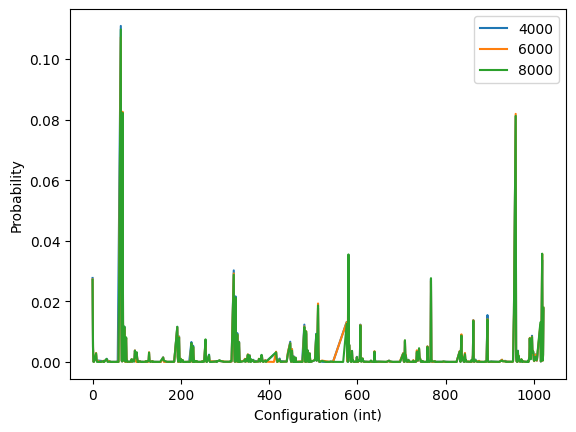

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
Wolff_cluster_Proposal_matrix(problem_inst=problem_inst)

0 {frozenset({0}): 0.2747066995628008, frozenset({0, 8}): 0.02651724329957494, frozenset({0, 8, 9}): 0.0046417446483931445, frozenset({0, 8, 5, 9}): 0.2062451924491667, frozenset({0, 1, 8, 9}): 0.0008378281373991178, frozenset({0, 1, 2, 8, 9}): 0.002063715917442503, frozenset({0, 1, 5, 8, 9}): 0.035633746967656345, frozenset({0, 1, 2, 5, 8, 9}): 0.08534692251464363, frozenset({0, 8, 5}): 0.07205835724601634, frozenset({0, 8, 2}): 0.015378347801084005, frozenset({0, 1, 2, 8}): 0.009732504921322398, frozenset({0, 8, 2, 9}): 0.0026919224898447267, frozenset({0, 2, 5, 8, 9}): 0.11714466304901704, frozenset({0, 8, 2, 5}): 0.04093501415714246, frozenset({0, 1, 2, 5, 8}): 0.025828016466304983, frozenset({0, 1, 8}): 0.003646230556357493, frozenset({0, 1, 5, 8}): 0.009908321957266224, frozenset({0, 5}): 0.003116563646190422, frozenset({0, 9, 5}): 0.0032973883414697904, frozenset({0, 1, 5, 9}): 6.774922852036348e-05, frozenset({0, 1, 2, 5, 9}): 0.00021345652739629544, frozenset({0, 2}): 0.046673

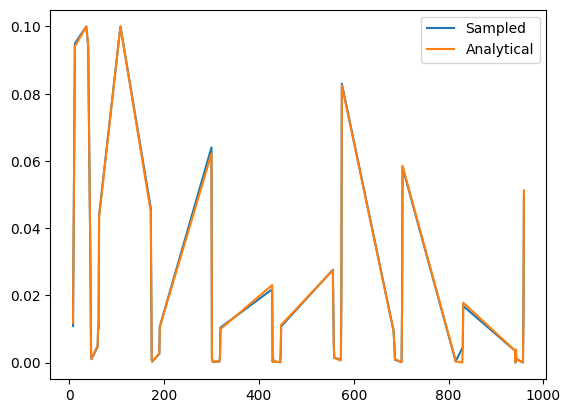

In [47]:
J_Q = problem_inst.J_quantum
J_Q = (J_Q + J_Q.T)   # Ensure symmetry
n = problem_inst.n
beta = problem_inst.T

configs = all_configs(n)
index = {tuple(c): i for i, c in enumerate(configs)}

Q = np.zeros((2**n, 2**n))

v = np.random.choice([1,-1],size=n)  

tm = time.time()
analytical = wolff_transition_probabilities(s=v, 
                              J=J_Q, beta=1, prob_threshold=1e-8)
print("Time taken for analytical:", time.time() - tm)

tm = time.time()
sampled = wolff_clustering_flipping_step(v, beta=1, J=J_Q, num_trials=4000)
print("Time taken for sampling:", time.time() - tm)


plot_sample_dict(sampled, label='Sampled')
plot_sample_dict(analytical, label='Analytical')
plt.legend()


In [253]:
sampled

{(1, 1, 1, 1): 0.7676623992413466,
 (1, 1, -1, -1): 0.000135473819684346,
 (1, -1, -1, 1): 0.007518796992481203,
 (1, 1, 1, -1): 0.10404389351757773,
 (1, -1, 1, -1): 0.009889588836957258,
 (1, 1, -1, 1): 0.001896633475580844,
 (1, -1, 1, 1): 0.009144482828693354,
 (-1, 1, -1, 1): 0.008263903000745107,
 (-1, 1, 1, 1): 0.06841427894059474,
 (-1, 1, 1, -1): 0.022149969518390572,
 (-1, -1, 1, 1): 0.000880579827948249}

In [107]:
# J_Q = problem_inst.J_quantum
# n = problem_inst.n
# beta = problem_inst.T

# configs = all_configs(n)
# index = {tuple(c): i for i, c in enumerate(configs)}

# Q = np.zeros((2**n, 2**n))

# v = np.array([1, 1, 1, 1, 1, 1, 1])  # Example configuration     
# wolff_clustering_flipping_step(v, beta=beta, J=J_Q, num_trials=2000), wolff_clustering_flipping_step(v, beta=beta, J=J_Q, num_trials=2000)

Starting problem instance 1 of 5 with n = 3
Instance 1, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.0000


C:\Users\vinit\AppData\Local\Temp\ipykernel_39256\4183202162.py:94: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,pd.DataFrame([results_datum])], ignore_index=True)


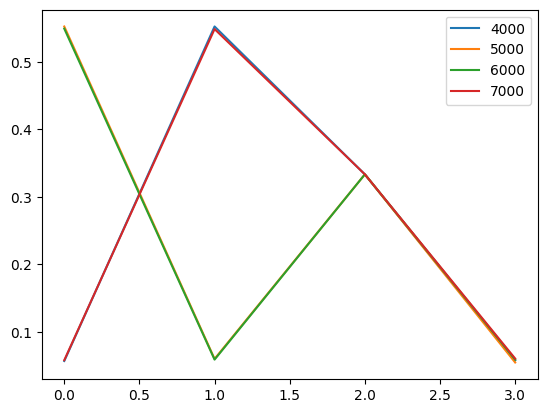

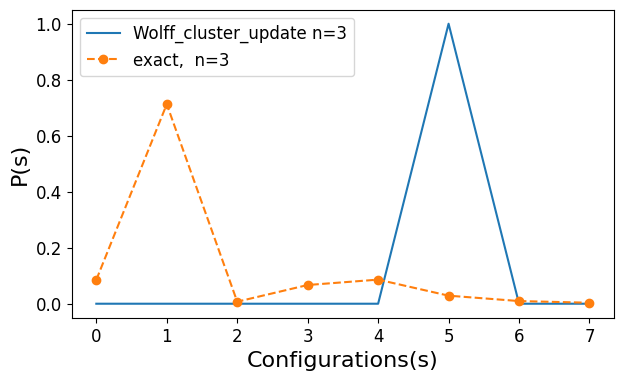

Starting problem instance 2 of 5 with n = 4
Instance 2, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.0000


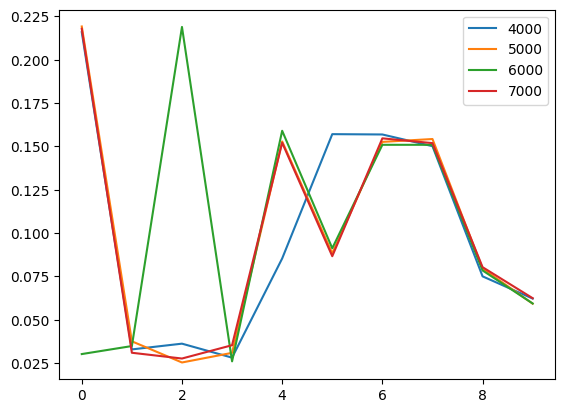

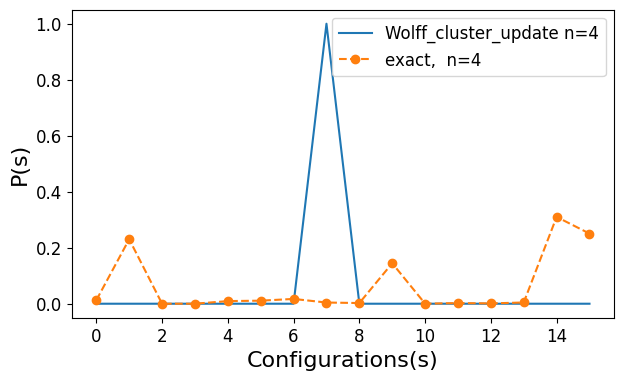

Starting problem instance 3 of 5 with n = 5
Instance 3, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.0000


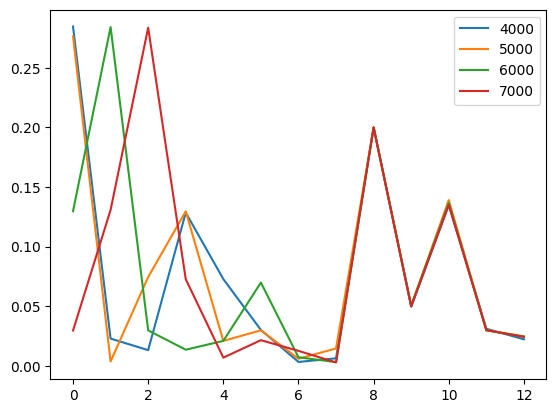

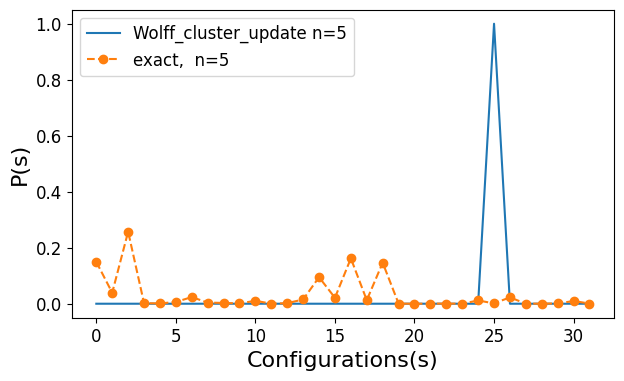

Starting problem instance 4 of 5 with n = 6
Instance 4, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.0000


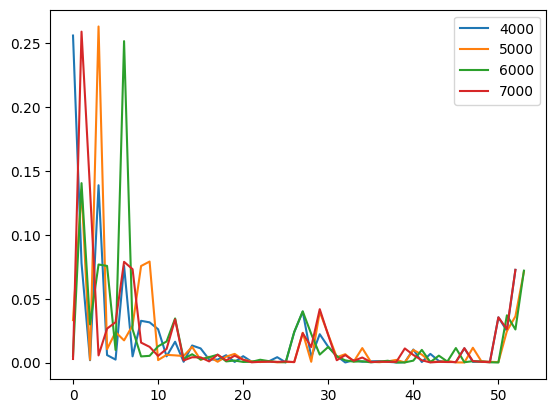

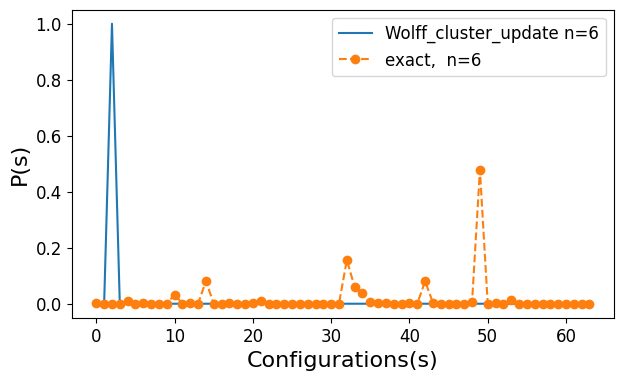

Starting problem instance 5 of 5 with n = 7
Instance 5, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.0000


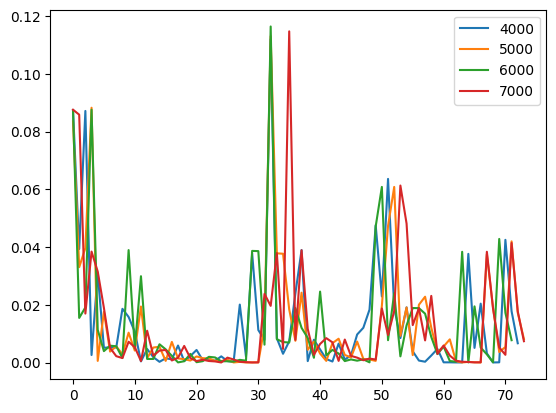

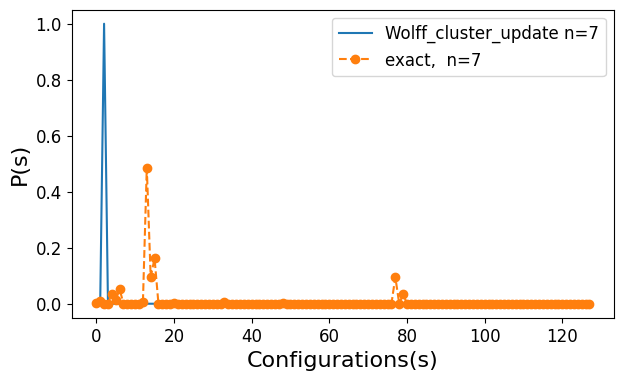

In [8]:
filepath = '/Users/vinit/Downloads/Research/Quantum-Sampling/Manas\' Proposals/'
filename_instances =  '/instances_new.pkl'
sample_size=1000

from tqdm import tqdm
instances = pd.read_pickle(filepath + filename_instances)
#tot_instances = np.max(instances['Instance Number'].values)
tot_instances = 5
results = pd.DataFrame(columns = [
    'Instance Number',
    'Spins', 
    'Temperature', 
    'Connectivity',
    'Proposal',
    'Acceptance',
#    'Mismatched',
    'Gap',
    'Gap Lazy'
        ])
T_logmesh = np.logspace(-3, 3, 50)
T_round = np.sort( np.kron(np.array([1,5]), 10.**np.arange(-3,4)))
T_lim = np.array([0, np.inf]) 
T_arr = np.unique( np.concatenate((T_logmesh, T_round, T_lim))) 
#T_arr = np.delete(T_arr, -2) 
T_arr = [1]
delta_step = 0.2


for instance_num in range(1, tot_instances+1):
    cond  = (instances['Instance Number']==instance_num)
    n            = instances[cond]['Spins'].values[0]
    connectivity = instances[cond]['Connectivity'].values[0]
    J            = instances[cond]['J'].values[0]
    h            = instances[cond]['h'].values[0]
    #J_mismatch   = instances[cond]['J Mismatch'].values[0]
    #h_mismatch   = instances[cond]['h Mismatch'].values[0]

    print('Starting problem instance', instance_num, 'of', tot_instances, 'with n =', n)

    problem_inst = ProblemInstance(J, h)
    #problem_inst_mismatch = ProblemInstance(J_mismatch, h_mismatch)
    #proposal_mats['quantum_avg'] = quantum_proposal_mat_avg(problem_inst)
    #proposal_mats['quantum_time_mid_gamma_mid'] = quantum_proposal_time_homogeneous(problem_inst, t_val="t_mid")
    #proposal_mats['quantum_time_mid_gamma_mid_Trotter'] = quantum_proposal_time_homogeneous_Trotter_circuit(problem_inst, delta_step, t_val="t_mid")
    
    #proposal_mats['quantum_time_uplim_gamma_mid'] = quantum_proposal_time_homogeneous(problem_inst, t_val="t-uplim")
    #proposal_mats['quantum_time_lowlim_gamma_mid'] = quantum_proposal_time_homogeneous(problem_inst, t_val="t-llim")

    #norm_diff_trotter_exact_proposal = np.linalg.norm(proposal_mats['quantum_time_mid_gamma_mid_Trotter']-proposal_mats['quantum_time_mid_gamma_mid'])
    #norm_exact_proposal = np.linalg.norm(proposal_mats['quantum_time_mid_gamma_mid'])

    for T in T_arr:
        problem_inst.T = T
        #problem_inst_mismatch.T = T 
        proposal_mats={}
        proposal_mats['Wolff_cluster_update'] = Wolff_cluster_Proposal_matrix(problem_inst)

        #for prop_type, accept_type in product(['local', 'uniform', 'quantum'], ['metropolis', 'glauber']):
        for prop_type, accept_type in product(['Wolff_cluster_update'], ['metropolis']):   #'local', 'uniform', 'quantum_avg', 'Wolff_cluster_update'   #'Haar', "Continuous-HMC", "adaptive_MC", "MALA_MC", 'quantum_time_mid_gamma_mid_Trotter',                
            # if prop_type == "Continuous-HMC":
            #     transition_mat = HMC_T_matrix(problem_inst, epsilon=0.2, L=10, alpha=3.0, num_samples=300, num_p_samples=30)

            # elif prop_type == "adaptive_MC":
            #     transition_mat = adaptive_metropolis_T_matrix(problem_inst, alpha=3.0, epsilon=0.2, num_samples=1000)

            # elif prop_type == "MALA_MC":
            #     transition_mat = adaptive_MALA_T_matrix(problem_inst, alpha=3.0, epsilon=0.2, num_samples=1000)

            transition_mat = make_transition_mat(problem_inst, proposal_mats[prop_type], acceptance=accept_type)
            
            if prop_type == '2-local':
                dist = np.sort( 1-np.abs(la.eigvals(transition_mat)) )
                gap = np.min(dist[2:])
            else:
                gap, _ = abs_spectral_gap(transition_mat)

            results_datum = {
                'Instance Number': instance_num,
                'Spins': n, 
                'Temperature': T, 
                'Connectivity': connectivity,
                'Proposal': prop_type,
                'Acceptance': accept_type,
                'Mismatched': False,
                'Gap': gap,
                "delta_time_step_Trotter": delta_step
            }

            #print(results_datum)

            print("Instance {}, T = {}, Proposal = {}, Acceptance = {}, Gap = {:.4f}".format(
                instance_num, T, prop_type, accept_type, gap))
            
            results = pd.concat([results,pd.DataFrame([results_datum])], ignore_index=True)

            
            # Proposal_object = All_proposals(inverse_temp=problem_inst.T, one_body_coeffs=problem_inst.h_quantum,
            #                two_body_coeffs = problem_inst.J_quantum)
            # print(sum(T[16,:]))
            # empirical_dist, key_list = Sampling_MCMC_trajectories(Proposal_object, 
            #                                      Transition_matrix=transition_mat, sample_size=sample_size, burn=sample_size//10)

            if prop_type in ['quantum_time_mid_gamma_mid_Trotter', 'Wolff_cluster_update',
                                            "Continuous-HMC", "adaptive_MC", "MALA_MC"]:
                empirical_dist, key_list = Sampling_MCMC_trajectories(problem_inst, 
                                                    Transition_matrix=transition_mat, sample_size=sample_size, burn=sample_size//10)

                fig, ax = plt.subplots(1, figsize=(7,4))
                if prop_type == 'quantum_time_mid_gamma_mid_Trotter':
                    prop_type = 'quantum_circ'
                ax.plot(empirical_dist, label=prop_type + ' n={}'.format(problem_inst.n))
                exact_dist = np.exp(-problem_inst.T*problem_inst.E_arr[::-1])
                exact_dist = exact_dist / np.sum(exact_dist)

                ax.plot(exact_dist, marker='o', linestyle='dashed', label='exact,  n={}'.format(problem_inst.n))
                
                ax.set_xlabel("Configurations(s)", fontsize=16)
                ax.set_ylabel("P(s)", fontsize=16)
                ax.legend(loc='best', fontsize=12)
                ax.tick_params(axis='both', which='major', labelsize=12)
                plt.savefig(os.getcwd() + "/Figures/{}_vs_configs_n_{}.png".format(prop_type, problem_inst.n), bbox_inches='tight')
                plt.show()

#results.to_pickle('results_new_all_prop.pkl')

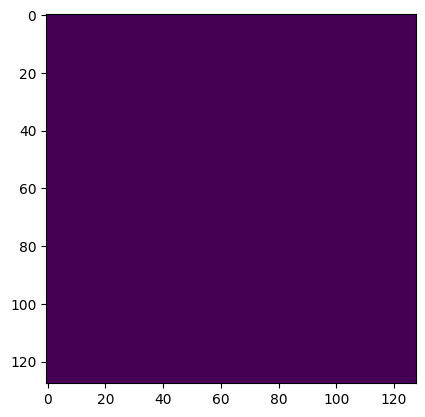

In [15]:
plt.imshow(transition_mat<0)

{'Instance Number': 1000,
 'Spins': 10,
 'Temperature': 1,
 'Connectivity': 'full',
 'Proposal': '2-local',
 'Acceptance': 'metropolis',
 'Mismatched': False,
 'Gap': 8.109154811308805e-06,
 'delta_time_step_Trotter': 0.2}

In [ ]:
results.to_csv('results_all_prop.csv', mode='a', header=not os.path.exists('results_all_prop.csv'), index=False)

In [ ]:
# Sort the keys of prop_probs using spinconf2int, then plot the values in sorted order
sorted_keys = sorted(prop_probs.keys(), key=lambda k: spinconf2int(np.array(k)))
sorted_ints = [spinconf2int(np.array(k)) for k in sorted_keys]
sorted_vals = [prop_probs[k] for k in sorted_keys]
plt.plot(sorted_ints, sorted_vals, label=str(num_trials))
plt.xlabel('Configuration (int)')
plt.ylabel('Probability')
plt.legend()
plt.show()